The goal of this project is to provide SyriaTel, a telecommunications company, solutions regarding customer retention. In this dataset, there were a variety of factors, and one of the aims was to determine the most important variables while determining if a customer would continue using SyriaTel’s services. In other words, identifying the areas where SyriaTel has the most room for improvement was a key focus. This way, I would be able to determine the factors that were most helpful and most costly to SyriaTel. For each model, we also used a 2×2 confusion matrix as well as four metrics (accuracy, recall, precision, and F1). The confusion matrices are an easy way to visualize the accuracy of each model (1=customer churned, 0=customer remained). Numbers in the top-left and bottom-right corners represent correct predictions, while the other corners represent incorrect ones. Accuracy is all about the percentage of predictions (whether or not a customer churned) that were correct. That is a very important metric, but F1 was also a key emphasis, as it considers both precision and recall. Therefore, a high F1 score generally indicates a model that is reliable all-around.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import json
import requests
import time
from bs4 import BeautifulSoup
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('Telecom.csv')

In [2]:
df.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [5]:
round(483/(483+2850),2)

0.14

In [6]:
df['churn'] = df['churn'].astype(int)

In [7]:
df['international plan'] = df['international plan'].replace(['no'],0)
df['international plan'] = df['international plan'].replace(['yes'],1)

In [8]:
df['voice mail plan'] = df['voice mail plan'].replace(['no'],0)
df['voice mail plan'] = df['voice mail plan'].replace(['yes'],1)

In [9]:
df['international plan'] = df['international plan'].astype(int)
df['voice mail plan'] = df['voice mail plan'].astype(int)

In [10]:
df.columns=df.columns.map(lambda x: x.replace('.','_').replace(' ','_').replace(',','_').replace('[','').replace(']','').replace('(','').replace(')',''))

In [11]:
df.drop(columns=['state'], inplace = True)
df.drop(columns=['phone_number'], inplace = True)

## 1. Linear regression

In [12]:
outcome='churn'
cols=[col for col in df.columns]
cols.remove('churn')
predictors='+'.join(cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     40.60
Date:                Thu, 31 Dec 2020   Prob (F-statistic):          6.43e-129
Time:                        20:44:30   Log-Likelihood:                -917.28
No. Observations:                3333   AIC:                             1873.
Df Residuals:                    3314   BIC:                             1989.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.4416      0.088     -5.012      0.000      -0.614      -0.269
account_length             0.0001      0.000      0.735      0.463      -0.000       0.000
area_code              -8.072e-05      0.000     -0.616      0.538      -0.000       0.000
international_plan         0.3023      0.019     16.070      0.000       0.265       0.339
voice_mail_plan           -0.1373      0.043     -3.216      0.001      -0.221      -0.054
number_vmail_messages      0.0020      0.001      1.415      0.157      -0.001       0.005
total_day_minutes          0.0342      0.329      0.104      0.917      -0.611       0.679
total_day_calls            0.0003      0.000      1.159      0.246      -0.000       0.001
total_day_charge          -0.1935      1.935     -0.100      0.920      -3.987       3.601
total_eve_minutes          0.0939      0.163      0.575      0.565      -0.226       0.414
total_eve_calls         8.013e-05      0.000      0.288      0.773      -0.000       0.001
total_eve_charge          -1.0973      1.922     -0.571      0.568      -4.866       2.672
total_night_minutes       -0.0375      0.087     -0.428      0.668      -0.209       0.134
total_night_calls       7.288e-05      0.000      0.257      0.797      -0.000       0.001
total_night_charge         0.8398      1.944      0.432      0.666      -2.972       4.652
total_intl_minutes        -0.3980      0.521     -0.763      0.445      -1.420       0.624
total_intl_calls          -0.0082      0.002     -3.646      0.000      -0.013      -0.004
total_intl_charge          1.5035      1.931      0.779      0.436      -2.282       5.289
customer_service_calls     0.0582      0.004     13.805      0.000       0.050       0.066
==============================================================================
Omnibus:                      820.813   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1611.571
Skew:                           1.499   Prob(JB):                         0.00
Kurtosis:                       4.616   Cond. No.                     2.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This linear regression attempt is insufficient. Given that our outcome variable is a True/False, it is difficult to imagine that a linear regression would give us a close fit. In addition, most of the variables appear to be statistically insignificant, as their p-values are above .05. There are not many takeaways we can confidently make. Surely, we can do better with a different algorithm.

## 2. Logistic regression

In [13]:
df.drop(columns=['account_length'], inplace = True)
df.drop(columns=['area_code'], inplace = True)

In [14]:
# Create dummy variables
relevant_columns = ['international_plan','voice_mail_plan','number_vmail_messages',
                    'total_day_minutes','total_day_calls','total_day_charge',
                    'total_eve_minutes','total_eve_calls','total_eve_charge',
                   'total_night_minutes','total_night_calls','total_night_charge',
                   'total_intl_minutes','total_intl_calls','total_intl_charge','customer_service_calls','churn']
df_logistic = pd.get_dummies(df[relevant_columns], drop_first=True, dtype=float)

df_logistic.shape

(3333, 17)

In [15]:
# Drop missing rows
df_logistic = df_logistic.dropna()
df_logistic.shape

(3333, 17)

In [16]:
df_logistic.head(3)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0


In [17]:
df_logistic_pairs = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_logistic_pairs['Pairs'] = list(zip(df_logistic_pairs.level_0, df_logistic_pairs.level_1))
df_logistic_pairs.set_index(['Pairs'], inplace = True)
df_logistic_pairs.drop(columns=['level_1', 'level_0'], inplace = True)
df_logistic_pairs.columns = ['Correlation']
df_logistic_pairs.drop_duplicates(inplace=True)
df_logistic_pairs[(df_logistic_pairs.Correlation>.65) & (df_logistic_pairs.Correlation<1)]

,Correlation
Pairs,
"(total_day_charge, total_day_minutes)",1.000000
"(total_eve_charge, total_eve_minutes)",1.000000
"(total_night_charge, total_night_minutes)",0.999999
"(total_intl_charge, total_intl_minutes)",0.999993
"(number_vmail_messages, voice_mail_plan)",0.956927


In [18]:
#These are perfect or near-perfect correlations. Trying to get rid of multicollinearity.
df_logistic.drop(columns=['total_day_minutes'], inplace = True)
df_logistic.drop(columns=['total_eve_minutes'], inplace = True)
df_logistic.drop(columns=['total_night_minutes'], inplace = True)
df_logistic.drop(columns=['total_intl_minutes'], inplace = True)
df_logistic.drop(columns=['number_vmail_messages'], inplace = True)
#Regarding multicollinearity removal, this appears to be sufficient,
#since no other pairs have a correlation coefficient above .65.

In [19]:
y = df_logistic['churn']
X = df_logistic.drop(columns=['churn'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

In [22]:
logreg = LogisticRegression(fit_intercept=False, C=1e8, solver='liblinear')

In [23]:
logreg.fit(X_train, y_train)

LogisticRegression(C=100000000.0, fit_intercept=False, solver='liblinear')

In [24]:
model_log = logreg.fit(X_train_scaled, y_train)
model_log

LogisticRegression(C=100000000.0, fit_intercept=False, solver='liblinear')

In [25]:
y_hat_train = logreg.predict(X_train_scaled)
y_hat_test = logreg.predict(X_test_scaled)

In [26]:
X = sm.tools.add_constant(X)
logistic_model = sm.Logit(y, X)
result = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.324624
         Iterations 7


In [27]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3333
Model:                          Logit   Df Residuals:                     3321
Method:                           MLE   Df Model:                           11
Date:                Thu, 31 Dec 2020   Pseudo R-squ.:                  0.2155
Time:                        20:44:30   Log-Likelihood:                -1082.0
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                2.266e-120
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.5299      0.708    -12.044      0.000      -9.918      -7.142
international_plan         2.0423      0.145     14.064      0.000       1.758       2.327
voice_mail_plan           -0.9382      0.145     -6.474      0.000      -1.222      -0.654
total_day_calls            0.0033      0.003      1.187      0.235      -0.002       0.009
total_day_charge           0.0763      0.006     11.986      0.000       0.064       0.089
total_eve_calls            0.0011      0.003      0.381      0.703      -0.004       0.006
total_eve_charge           0.0849      0.013      6.322      0.000       0.059       0.111
total_night_calls          0.0004      0.003      0.154      0.877      -0.005       0.006
total_night_charge         0.0809      0.025      3.283      0.001       0.033       0.129
total_intl_calls          -0.0909      0.025     -3.645      0.000      -0.140      -0.042
total_intl_charge          0.3229      0.075      4.281      0.000       0.175       0.471
customer_service_calls     0.5143      0.039     13.125      0.000       0.438       0.591
==========================================================================================
"""

In [28]:
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report,precision_score, recall_score, accuracy_score, f1_score

def performance_results(trainx, trainy, train_prediction, testx, testy, test_prediction, model):  
    
    print("\n")
    
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))       
    print(f'Train Set Accuracy: {accuracy_score(trainy, train_prediction):.4f}')
    print(f'Train Set Recall: {recall_score(trainy, train_prediction):.4f}')
    print(f'Train Set Precision: {precision_score(trainy, train_prediction):.4f}')
    print(f'Train Set F1: {f1_score(trainy, train_prediction):.4f}')

    print("\n")
    
    print("Test Score Results")    
    print(classification_report(testy, test_prediction))       
    print(f'Test Set Accuracy: {accuracy_score(testy, test_prediction):.4f}')
    print(f'Test Set Recall: {recall_score(testy, test_prediction):.4f}')
    print(f'Test Set Precision: {precision_score(testy, test_prediction):.4f}')
    print(f'Test Set F1: {f1_score(testy, test_prediction):.4f}')
    
    print("\n")
    print("Test Set Confusion Matrix")
    plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues)



Train Score Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2131
           1       0.15      1.00      0.26       368

    accuracy                           0.15      2499
   macro avg       0.07      0.50      0.13      2499
weighted avg       0.02      0.15      0.04      2499

Train Set Accuracy: 0.1473
Train Set Recall: 1.0000
Train Set Precision: 0.1473
Train Set F1: 0.2567


Test Score Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       719
           1       0.14      1.00      0.24       115

    accuracy                           0.14       834
   macro avg       0.07      0.50      0.12       834
weighted avg       0.02      0.14      0.03       834

Test Set Accuracy: 0.1379
Test Set Recall: 1.0000
Test Set Precision: 0.1379
Test Set F1: 0.2424


Test Set Confusion Matrix


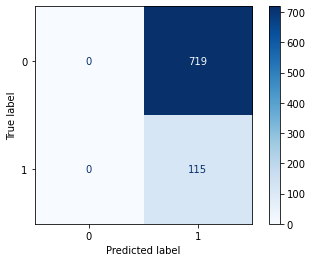

In [29]:
#Predict the model, evaluate results
test_preds = logreg.predict(X_test)
train_preds = logreg.predict(X_train)
performance_results(X_train, y_train, train_preds, X_test, y_test, test_preds, logreg)

This is the first of many 2x2 confusion matrices we will observe.

The top-left and bottom-right corners represent correct predictions (top-left: customer remained with SyriaTel, which the model predicted; bottom-right: customer did not remain with SyriaTel, which the model predicted).

The top-right and bottom-left corners represent incorrect predictions (top-right: customer remained with SyriaTel, while the model predicted the customer would switch; bottom-left: customer did not remain with SyriaTel, while the model predicted the customer would remain).

In [30]:
df_logistic['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [31]:
y = df_logistic['churn']
X = df_logistic.drop(columns=['churn'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [32]:
print(y_train.value_counts())
print(y_test.value_counts())

0    2131
1     368
Name: churn, dtype: int64
0    719
1    115
Name: churn, dtype: int64


AUC: 0.7627381024369595


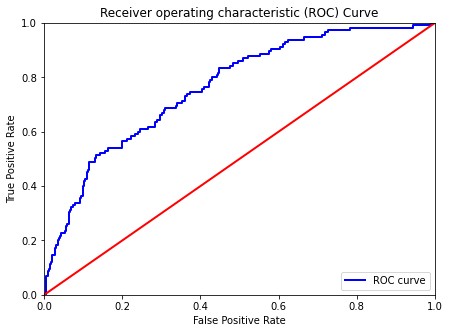

In [33]:
logreg=LogisticRegression(fit_intercept=False)
y_score=logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds=roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression(C=0.0001, fit_intercept=False, solver='liblinear')
AUC for 0.0001: 0.5655923081574651


LogisticRegression(C=0.001, fit_intercept=False, solver='liblinear')
AUC for 0.001: 0.6269093547801898


LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.7630888311060048


LogisticRegression(C=1000, fit_intercept=False, solver='liblinear')
AUC for 1000: 0.7640926407449959




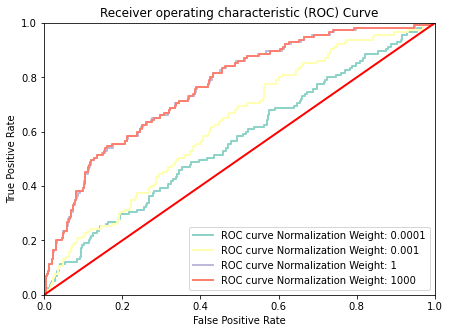

In [34]:
C_param_range = [.0001, .001, 1, 1000]
names = [.0001, .001, 1, 1000]
colors = sns.color_palette('Set3')
plt.figure(figsize=(7, 5))
for n, c in enumerate(C_param_range):
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)
    y_hat_test=logreg.predict(X_test)
    y_score=logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('\n')
    lw=2
    plt.plot(fpr, tpr, color=colors[n],
             lw=2, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
print('Before:')
print(y_train.value_counts()) 
print('\n')

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

print('After:')
print(pd.Series(y_train_resampled).value_counts()) 

Before:
0    2131
1     368
Name: churn, dtype: int64


After:
1    2131
0    2131
Name: churn, dtype: int64


LogisticRegression(C=0.0001, fit_intercept=False, solver='liblinear')
AUC for 0.0001: 0.6309124992441193


LogisticRegression(C=0.001, fit_intercept=False, solver='liblinear')
AUC for 0.001: 0.6911773598597085


LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.7662816714035193


LogisticRegression(C=1000, fit_intercept=False, solver='liblinear')
AUC for 1000: 0.7666444941646007




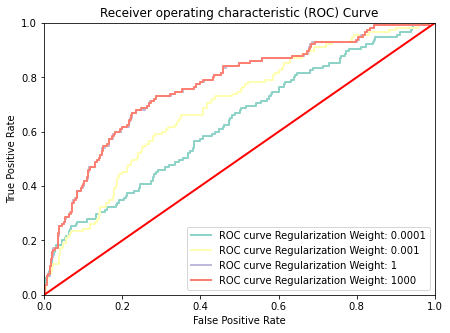

In [36]:
C_param_range = [.0001, .001, 1, 1000]
names = [.0001, .001, 1, 1000]
colors = sns.color_palette('Set3', n_colors=len(names))
plt.figure(figsize=(7, 5))
for n, c in enumerate(C_param_range):
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('\n')
    lw=2
    plt.plot(fpr, tpr, color=colors[n],
             lw=2, label='ROC curve Regularization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



Train Score Results
              precision    recall  f1-score   support

           0       0.94      0.68      0.78      2131
           1       0.28      0.73      0.40       368

    accuracy                           0.68      2499
   macro avg       0.61      0.70      0.59      2499
weighted avg       0.84      0.68      0.73      2499

Train Set Accuracy: 0.6839
Train Set Recall: 0.7283
Train Set Precision: 0.2797
Train Set F1: 0.4042


Test Score Results
              precision    recall  f1-score   support

           0       0.94      0.68      0.79       719
           1       0.27      0.73      0.39       115

    accuracy                           0.69       834
   macro avg       0.60      0.70      0.59       834
weighted avg       0.85      0.69      0.73       834

Test Set Accuracy: 0.6859
Test Set Recall: 0.7304
Test Set Precision: 0.2667
Test Set F1: 0.3907


Test Set Confusion Matrix


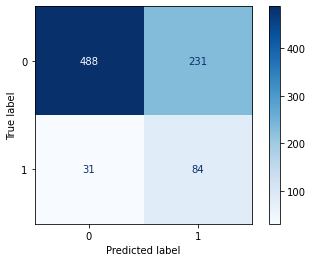

In [37]:
#Predict the model, evaluate results
test_preds = logreg.predict(X_test)
train_preds = logreg.predict(X_train)
performance_results(X_train, y_train, train_preds, X_test, y_test, test_preds, logreg)

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3333
Model:                          Logit   Df Residuals:                     3321
Method:                           MLE   Df Model:                           11
Date:                Thu, 31 Dec 2020   Pseudo R-squ.:                  0.2155
Time:                        20:44:32   Log-Likelihood:                -1082.0
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                2.266e-120
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.5299      0.708    -12.044      0.000      -9.918      -7.142
international_plan         2.0423      0.145     14.064      0.000       1.758       2.327
voice_mail_plan           -0.9382      0.145     -6.474      0.000      -1.222      -0.654
total_day_calls            0.0033      0.003      1.187      0.235      -0.002       0.009
total_day_charge           0.0763      0.006     11.986      0.000       0.064       0.089
total_eve_calls            0.0011      0.003      0.381      0.703      -0.004       0.006
total_eve_charge           0.0849      0.013      6.322      0.000       0.059       0.111
total_night_calls          0.0004      0.003      0.154      0.877      -0.005       0.006
total_night_charge         0.0809      0.025      3.283      0.001       0.033       0.129
total_intl_calls          -0.0909      0.025     -3.645      0.000      -0.140      -0.042
total_intl_charge          0.3229      0.075      4.281      0.000       0.175       0.471
customer_service_calls     0.5143      0.039     13.125      0.000       0.438       0.591
==========================================================================================
"""

In [39]:
df_logistic.corr()['international_plan'].sort_values(ascending=False).head(4)

international_plan    1.000000
churn                 0.259852
total_day_charge      0.049398
total_intl_charge     0.045780
Name: international_plan, dtype: float64

In [40]:
df_logistic.head(3)

,international_plan,voice_mail_plan,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,0,1,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,0,1,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0


We can make a few takeaways from our logistic regression. Customers who have an voicemail plan are largely satisfied with it, as they are much less likely to switch to a competitor. By contrast, customers with an international plan are much more likely to switch than customers who do not have one.

Let's review how our logistic regression's results looked before balancing our classes with SMOTE and compare them with our results after.

Since those initial results, our accuracy dropped from .85 to .68. Before the class balance, our model correctly identified whether or not a customer would remain with SyriaTel 85% of the time, but now, it only predicts the correct outcome 68% of the time.

As for our recall, that improved dramatically since our SMOTE usage, going from .17 to .73. Recall is calculated by dividing the number of true positives by the number of actual total positives. For out most recent model, 84/(84+31), or .73.

The precision decreased after the class balance, from .52 to .26. Precision is calculated by using the amount of true positives divided by the number of predicted positives. In other words, for our more recent model, we are looking for the amount of customers who discontinued services with SyriaTel out of all customers our model believed to churn. This is 84/(84+235), which is not a good rate. 

The F1 increased from .26 to just under .40. This metric is calculated as 2 * Recall * Precision/(Recall+Precision). As a result, the F1 score cannot be high without both precision and recall both being high. So, the F1 score is a good measure of a model's all-around reliability. While this metric improved significantly, it is not as high as we would like it to be. Let's try other algorithms.

## 3. K Nearest Neighbors

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

knn_initial = KNeighborsClassifier(n_neighbors=1)
knn_initial.fit(X_train_scaled, y_train)

y_predict_test = knn_initial.predict(X_test_scaled)
y_predict_train = knn_initial.predict(X_train_scaled)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2131
           1       1.00      1.00      1.00       368

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499

Train Set Accuracy: 1.0000
Train Set Recall: 1.0000
Train Set Precision: 1.0000
Train Set F1: 1.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       719
           1       0.57      0.47      0.52       115

    accuracy                           0.88       834
   macro avg       0.75      0.71      0.72       834
weighted avg       0.87      0.88      0.87       834

Test Set Accuracy: 0.8789
Test Set Recall: 0.4696
Test Set Precision: 0.5745
Test Set F1: 0.5167


Test Set Confusion Matrix


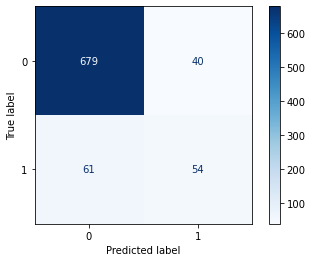

In [43]:
performance_results(X_train_scaled, y_train, y_predict_train, X_test_scaled, y_test, y_predict_test, knn_initial)

We will need to reinstantiate the model with the most appropriate value for k. By default, it will assume the best value is 5, which is probably not the case.

In [44]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=35):
    best_k=0
    best_score=0
    for k in range(min_k, max_k+1, 2):
        knn=KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions=knn.predict(X_test)
        f1=f1_score(y_test, predictions)
        if f1>best_score:
            best_k=k
            best_score=f1
    
    print("Best value for k: {}".format(best_k))
    print("F1: {}".format(best_score))

In [45]:
find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

Best value for k: 7
F1: 0.5680473372781064


Turns out the best value for k is 7. Time to reinstantiate the model with this information.

In [46]:
knn_k_7=KNeighborsClassifier(n_neighbors=7)
knn_k_7.fit(X_train_scaled, y_train)

y_predict_test2=knn_k_7.predict(X_test_scaled)
y_predict_train2=knn_k_7.predict(X_train_scaled)



Train Score Results
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2131
           1       0.89      0.43      0.58       368

    accuracy                           0.91      2499
   macro avg       0.90      0.71      0.76      2499
weighted avg       0.91      0.91      0.89      2499

Train Set Accuracy: 0.9084
Train Set Recall: 0.4293
Train Set Precision: 0.8927
Train Set F1: 0.5798


Test Score Results
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       719
           1       0.89      0.42      0.57       115

    accuracy                           0.91       834
   macro avg       0.90      0.70      0.76       834
weighted avg       0.91      0.91      0.90       834

Test Set Accuracy: 0.9125
Test Set Recall: 0.4174
Test Set Precision: 0.8889
Test Set F1: 0.5680


Test Set Confusion Matrix


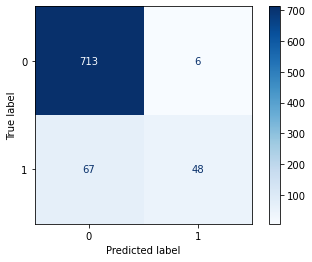

In [47]:
performance_results(X_train_scaled, y_train, y_predict_train2, X_test_scaled, y_test, y_predict_test2, knn_k_7)

In this model, we see a high level of accuracy and precision, but the other metrics have a lot of room for improvement. This is because we have a large number of customers who the model falsely identified as customers who remained with SyriaTel.

## 4. Decision Tree

In [48]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
decisiontree = DecisionTreeClassifier(random_state=10)
decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [49]:
#predict the train and test data
y_preds = decisiontree.predict(X_test)
y_preds2 = decisiontree.predict(X_train)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2131
           1       1.00      1.00      1.00       368

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499

Train Set Accuracy: 1.0000
Train Set Recall: 1.0000
Train Set Precision: 1.0000
Train Set F1: 1.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       719
           1       0.70      0.77      0.73       115

    accuracy                           0.92       834
   macro avg       0.83      0.86      0.84       834
weighted avg       0.93      0.92      0.92       834

Test Set Accuracy: 0.9221
Test Set Recall: 0.7739
Test Set Precision: 0.6953
Test Set F1: 0.7325


Test Set Confusion Matrix


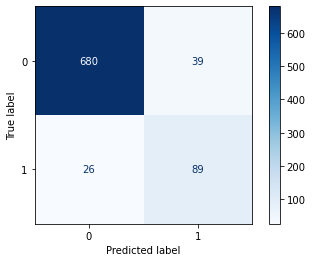

In [50]:
performance_results(X_train, y_train, y_preds2, X_test, y_test, y_preds, decisiontree)

In [51]:
#Retry the classifier with Entropy

decisiontree2 = DecisionTreeClassifier(criterion='entropy', random_state=35)
decisiontree2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=35)



Train Score Results
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2131
           1       0.49      0.42      0.46       368

    accuracy                           0.85      2499
   macro avg       0.70      0.67      0.68      2499
weighted avg       0.84      0.85      0.85      2499

Train Set Accuracy: 0.8511
Train Set Recall: 0.4239
Train Set Precision: 0.4937
Train Set F1: 0.4561


Test Score Results
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       719
           1       0.44      0.43      0.43       115

    accuracy                           0.85       834
   macro avg       0.68      0.67      0.67       834
weighted avg       0.84      0.85      0.85       834

Test Set Accuracy: 0.8465
Test Set Recall: 0.4261
Test Set Precision: 0.4414
Test Set F1: 0.4336


Test Set Confusion Matrix


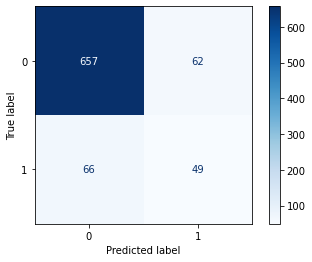

In [52]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()

bayes.fit(X_train, y_train)
GaussianNB()

#Predict the model, evaluate results
test_preds = bayes.predict(X_test)
train_preds = bayes.predict(X_train)
performance_results(X_train, y_train, train_preds, X_test, y_test, test_preds, bayes)

In [53]:
#predict the train and test data
y_ent_preds = decisiontree2.predict(X_test)
y_ent_preds2 = decisiontree2.predict(X_train)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2131
           1       1.00      1.00      1.00       368

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499

Train Set Accuracy: 1.0000
Train Set Recall: 1.0000
Train Set Precision: 1.0000
Train Set F1: 1.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       719
           1       0.65      0.81      0.72       115

    accuracy                           0.91       834
   macro avg       0.81      0.87      0.83       834
weighted avg       0.92      0.91      0.92       834

Test Set Accuracy: 0.9137
Test Set Recall: 0.8087
Test Set Precision: 0.6503
Test Set F1: 0.7209


Test Set Confusion Matrix


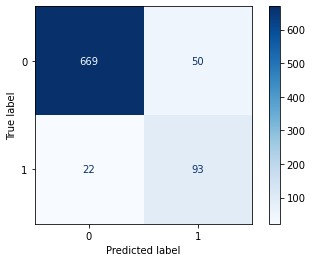

In [54]:
#Evaluate the results 
performance_results(X_train, y_train, y_ent_preds2, X_test, y_test, y_ent_preds, decisiontree2)

In [55]:
#Tune the max_depth hyperparameter to see if it improves results 
decisiontree3 = DecisionTreeClassifier(random_state=10, criterion="entropy", max_depth=3)
decisiontree3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)

In [56]:
#predict the train and test data
y_testpreds = decisiontree3.predict(X_test)
y_trainpreds = decisiontree3.predict(X_train)



Train Score Results
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2131
           1       0.88      0.41      0.56       368

    accuracy                           0.90      2499
   macro avg       0.89      0.70      0.75      2499
weighted avg       0.90      0.90      0.89      2499

Train Set Accuracy: 0.9048
Train Set Recall: 0.4076
Train Set Precision: 0.8824
Train Set F1: 0.5576


Test Score Results
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       719
           1       0.81      0.41      0.54       115

    accuracy                           0.91       834
   macro avg       0.86      0.70      0.75       834
weighted avg       0.90      0.91      0.89       834

Test Set Accuracy: 0.9053
Test Set Recall: 0.4087
Test Set Precision: 0.8103
Test Set F1: 0.5434


Test Set Confusion Matrix


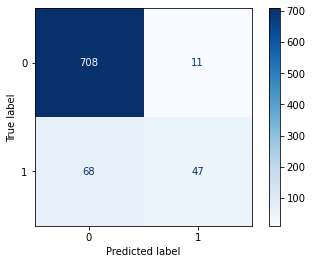

In [57]:
#Evaluate the results 
performance_results(X_train, y_train, y_trainpreds, X_test, y_test, y_testpreds, decisiontree3)

With the decision tree, we see generally the same strengths and weaknesses as we had with K Nearest Neighbors. Once again, we have high accuracy and precision, but we still have more false negatives than we would like.

## 5. Ensemble Methods

Trying to build on the decision tree model by using a random forest model, which relies on decision trees.

In [58]:
#Instansiate and fit the model.
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=50)
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=50)

In [59]:
bagged_predictions_train = bagged_tree.predict(X_train)
bagged_predictions_test = bagged_tree.predict(X_test)



Train Score Results
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2131
           1       0.97      0.76      0.86       368

    accuracy                           0.96      2499
   macro avg       0.97      0.88      0.92      2499
weighted avg       0.96      0.96      0.96      2499

Train Set Accuracy: 0.9620
Train Set Recall: 0.7636
Train Set Precision: 0.9723
Train Set F1: 0.8554


Test Score Results
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       719
           1       0.83      0.76      0.79       115

    accuracy                           0.94       834
   macro avg       0.90      0.87      0.88       834
weighted avg       0.94      0.94      0.94       834

Test Set Accuracy: 0.9448
Test Set Recall: 0.7565
Test Set Precision: 0.8286
Test Set F1: 0.7909


Test Set Confusion Matrix


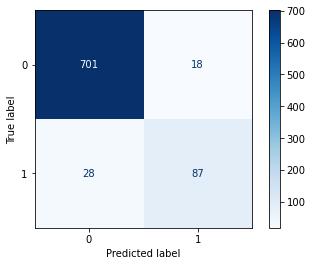

In [60]:
performance_results(X_train, y_train, bagged_predictions_train, X_test, y_test, bagged_predictions_test, bagged_tree)

In [61]:
#Instansiate the model, select hyperparameters to run through, fit the model.
randomforest = RandomForestClassifier(max_depth=10, criterion='gini', n_estimators=10, max_features=10)
randomforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10, n_estimators=10)

In [62]:
#Make predictions on the model.
random_forest_train = randomforest.predict(X_train)
random_forest_test = randomforest.predict(X_test)



Train Score Results
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2131
           1       1.00      0.87      0.93       368

    accuracy                           0.98      2499
   macro avg       0.99      0.94      0.96      2499
weighted avg       0.98      0.98      0.98      2499

Train Set Accuracy: 0.9812
Train Set Recall: 0.8723
Train Set Precision: 1.0000
Train Set F1: 0.9318


Test Score Results
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       719
           1       0.84      0.80      0.82       115

    accuracy                           0.95       834
   macro avg       0.90      0.89      0.89       834
weighted avg       0.95      0.95      0.95       834

Test Set Accuracy: 0.9508
Test Set Recall: 0.8000
Test Set Precision: 0.8364
Test Set F1: 0.8178


Test Set Confusion Matrix


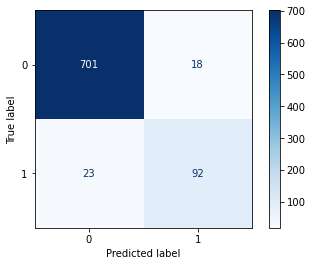

In [63]:
performance_results(X_train, y_train, random_forest_train, X_test, y_test, random_forest_test, randomforest)

In [64]:
#Create graph that displays the impact each figure makes on the dependent variable.
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(6,6))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

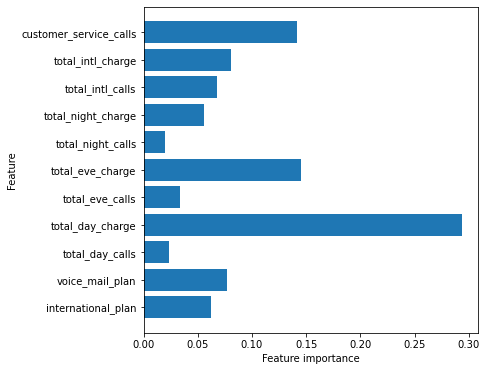

In [65]:
#View the features of the first tree.
rf_feature_importance_tree_1 = randomforest.estimators_[0]
plot_feature_importances(rf_feature_importance_tree_1)

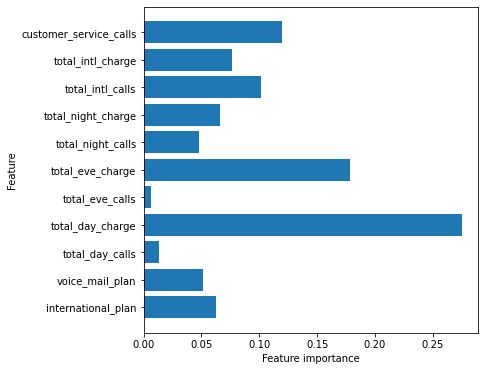

In [66]:
#View the features of the second tree.
rf_feature_importance_tree_2 = randomforest.estimators_[1]
plot_feature_importances(rf_feature_importance_tree_2)

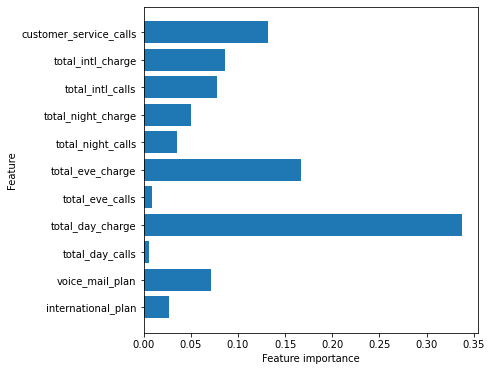

In [67]:
#View the features of the third tree.
rf_feature_importance_tree_3 = randomforest.estimators_[2]
plot_feature_importances(rf_feature_importance_tree_3)

In all three trees, we saw that total_day_charge, customer_service_calls, and international_plan are important features.

In [68]:
from sklearn.model_selection import cross_val_score, GridSearchCV

#Using GridSearch to improve the Random Tree model.
rfc = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rfc, X_train, y_train, cv=3))
round(mean_rf_cv_score, 3)

0.944

This model an excellent cross-validation score of over 94%. It will be difficult to improve this. A high cross-validation score means that the model is consistent across different subsets of data and tends not to overfit, making it more reliable.

Let's observe the international plan field, which seems to be among the most important features.

In [69]:
df_international_only = df.loc[df.international_plan == 1]
df_international_only.head(2)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
3,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [70]:
df_international_only.churn.value_counts().sort_index()

0    186
1    137
Name: churn, dtype: int64

In [71]:
round(137/(137+186),3)

0.424

In [72]:
df_no_international = df.loc[df.international_plan == 0]
df_no_international.head(2)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0
1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0


In [73]:
df_no_international.churn.value_counts().sort_index()

0    2664
1     346
Name: churn, dtype: int64

In [74]:
round(346/(346+2664),3)

0.115

During our logistic regression attempts, we observed that customers with international plans seemed to be more likely to churn than others, and this confirms that conclusion. The feature trees lead us to believe it is one of the most important features when determining churn rate. Roughly 42% of customers with an international plan switch, while only about 11% of customers without an international plan churn.

We also see that total_day_charge is the most important feature, according to those visuals. Let's compare the behaviors of customers in the top 5% (2 or more standard deviations above the mean) of total_day_charge versus all others.

In [75]:
for i in range(95, 96):
    q = i / 100
    print('{} percentile: {}'.format(q, df['total_day_charge'].quantile(q=q)))

0.9 percentile: 42.428000000000004
0.91 percentile: 43.01
0.92 percentile: 43.682
0.93 percentile: 44.47800000000001
0.94 percentile: 45.2016
0.95 percentile: 46.02799999999999
0.96 percentile: 46.6944
0.97 percentile: 47.8008
0.98 percentile: 49.30600000000001
0.99 percentile: 51.876799999999996


In [76]:
df_top_charges = df.loc[df.total_day_charge >= 46.028]
df_top_charges.head(2)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
3,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
15,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1


In [77]:
df_top_charges.churn.value_counts().sort_index()

0     66
1    101
Name: churn, dtype: int64

In [78]:
round(101/(101+66),3)

0.605

In [79]:
df_normal_charges = df.loc[df.total_day_charge <= 46.028]
df_normal_charges.head(2)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0
1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0


In [80]:
df_normal_charges.churn.value_counts().sort_index()

0    2784
1     382
Name: churn, dtype: int64

In [81]:
round(382/(382+2784),3)

0.121

Customers in the top 5% of total daily charge switched to another company over 60% of the time, while others chured at a rate of only 12%.

The feature importance trees correctly identified some very useful factors in determining whether customers decide to remain with SyriaTel or not. SyriaTel should consider adding incentives for customers paying more than $46 or so per day. These customers are among SyriaTel's most active, yet many of them are unsatisfied with the services. These customers are especially costly for SyriaTel to lose.

In addition, the satisfaction rate among customers with an international plan is also low. SyriaTel should delve into what is making these customers switch companies.

In [84]:
for i in range(95, 96):
    q = i / 100
    print('{} percentile: {}'.format(q, df['customer_service_calls'].quantile(q=q)))

0.95 percentile: 4.0


5% of customers in the dataset made 4 or more service calls. Let's compare churn rates for customers at/above this amount versus those with a smaller amount.

In [85]:
df_high_service_calls = df.loc[df.customer_service_calls >= 4]
df_high_service_calls.head(2)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
10,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1
14,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0


In [86]:
df_high_service_calls.churn.value_counts().sort_index()

0    129
1    138
Name: churn, dtype: int64

In [87]:
round(138/(138+129),3)

0.517

In [88]:
df_normal_service_calls = df.loc[df.customer_service_calls < 4]
df_normal_service_calls.head(2)

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0
1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0


In [89]:
df_normal_service_calls.churn.value_counts().sort_index()

0    2721
1     345
Name: churn, dtype: int64

In [90]:
round(345/(345+2721),3)

0.113

The churn rate for customers who made 4 or more service calls was above 52%, much higher than the churn rate for all others (11%). SyriaTel should do what it can to reduce the amount of service calls. This can be done by making answers/solutions more easily accessible to customers. Also, fewer customers making service calls could reduce costs, as fewer resources would be required to answer these questions.